# 🧠 **Análisis integrado de coexpresión y redes de interacción proteica centrado en SNCA para la identificación de genes candidatos asociados a procesos neurodegenerativos**

---


Proyecto final Bioinfromatica

BRIEGA, Ariana M.

# 📚 Librerias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pathlib import Path
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import accuracy_score

import matplotlib.colors as mcolors
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, leaves_list
import seaborn as sns
import networkx as nx

#📑 Base de Datos


---



Para el presente trabajo se utilizó un conjunto de datos público disponible en la base Gene Expression Omnibus (GEO), dependiente del National Center for Biotechnology Information (NCBI).

El dataset seleccionado fue GSE7621, titulado “*Gene expression profiling of Parkinson’s disease substantia nigra*”. Este estudio forma parte de una línea de investigación destinada a caracterizar los cambios en la expresión génica en la sustancia negra del cerebro, una región crítica para el control del movimiento y una de las más afectadas en la enfermedad de Parkinson.

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi

## 💻 Analisis previo

### 📊 Preparacion de datasets

---

En esta etapa realicé la preparación del dataset, partiendo de los archivos obtenidos a través de la plataforma Galaxy. A partir del dataset original GSE7621 descargado de la base de datos GEO, trabajé sobre el archivo series matrix para generar una matriz de expresión limpia y ordenada.
En Galaxy utilicé una serie de pasos intermedios para organizar la información: primero limpié la matriz eliminando datos no biológicos y ajustando los encabezados; luego, a partir del archivo de anotación de la plataforma, generé una tabla con las correspondencias entre los identificadores de los microarreglos (ID_REF) y los símbolos génicos. Finalmente, ordené ambas tablas para asegurar que los identificadores coincidieran correctamente antes de su integración.

Con los archivos procesados en Galaxy, continué el análisis en Python. Allí uní la matriz de expresión por identificador con la tabla de anotación (ID ↔ símbolo génico) para asignar a cada valor de expresión su correspondiente gen. Posteriormente, convertí todas las expresiones a formato numérico y agrupé los registros que medían el mismo gen, calculando el promedio de sus valores. Este paso permite pasar del nivel de identificador al nivel de gen, reduciendo redundancias y mejorando la interpretación biológica.

El resultado de este proceso fue la generación de dos archivos principales: uno con la matriz de expresión anotada (Matriz_con_GeneSymbol.tsv) y otro con la matriz consolidada por gen (Matriz_por_Gen.tsv), que servirá como base para los análisis de variabilidad, clustering y redes de coexpresión posteriores.

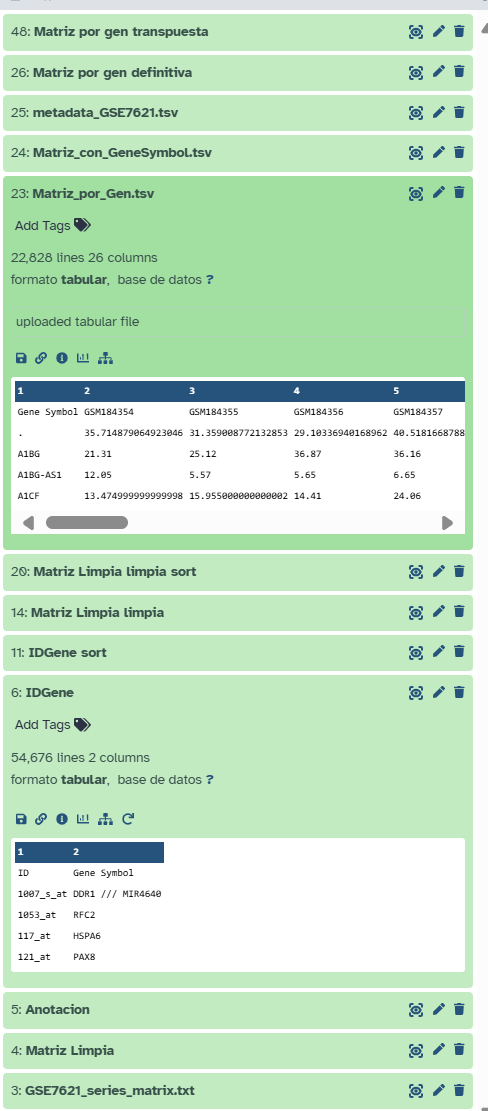

In [ ]:
matrix_path = "Galaxy20-[Matriz Limpia limpia sort].tabular"  # ID_REF + GSM…
idgene_path = "Galaxy11-[IDGene sort].tabular"                # 2 columnas: ID y Gene Symbol

# 1) Leer archivos (tabulados)
expr = pd.read_csv(matrix_path, sep="\t", dtype=str)
idg  = pd.read_csv(idgene_path, sep="\t", dtype=str)

# Asegurar nombres limpios de columnas
expr.columns = [c.strip().strip('"') for c in expr.columns]
idg.columns  = [c.strip().strip('"') for c in idg.columns]

# Detectar columnas de ID y “Gene Symbol” en IDGene
id_col = None; sym_col = None
for c in idg.columns:
    cl = c.lower().replace(" ", "")
    if cl in ("id","id_ref","probesetid","probeid","probeset"):
        id_col = id_col or c
    if cl in ("genesymbol","genesymbol(s)","symbol"):
        sym_col = c
if id_col is None and "ID" in idg.columns: id_col = "ID"
if sym_col is None:
    for c in idg.columns:
        if "Gene" in c and "Symbol" in c: sym_col = c; break
assert id_col and sym_col, f"No encuentro columnas en {idgene_path}: {list(idg.columns)}"

idg = idg[[id_col, sym_col]].rename(columns={id_col: "ID", sym_col: "Gene Symbol"})
# Limpiar símbolos (tomar el primero si hay '///' o comas)
idg["Gene Symbol"] = (idg["Gene Symbol"].fillna("")
                      .astype(str).str.split("///").str[0]
                      .str.split(",").str[0].str.strip())

# 2) Merge por ID_REF ↔ ID
if "ID_REF" not in expr.columns:
    # por si la primera columna no se llama así
    expr = expr.rename(columns={expr.columns[0]: "ID_REF"})
merged = expr.merge(idg, left_on="ID_REF", right_on="ID", how="inner")

# Reordenar: ID_REF | GSM… | Gene Symbol
sample_cols = [c for c in merged.columns if c not in ("ID_REF","ID","Gene Symbol")]
merged = merged[["ID_REF"] + sample_cols + ["Gene Symbol"]]

# Convertir expresiones a numérico
for c in sample_cols:
    merged[c] = pd.to_numeric(merged[c], errors="coerce")

# 3) Colapsar probes → nivel gen (media)
merged_valid = merged[merged["Gene Symbol"].notna() & (merged["Gene Symbol"]!="")].copy()
gene_mat = merged_valid.groupby("Gene Symbol", as_index=False)[sample_cols].mean(numeric_only=True)

# 4) Guardar TSVs
merged.to_csv("Matriz_con_GeneSymbol.tsv", sep="\t", index=False)
gene_mat.to_csv("Matriz_por_Gen.tsv", sep="\t", index=False)

print("Listo ✅")
print("• Matriz + símbolo:", "Matriz_con_GeneSymbol.tsv")
print("• Matriz por gen :", "Matriz_por_Gen.tsv")


Listo ✅
• Matriz + símbolo: Matriz_con_GeneSymbol.tsv
• Matriz por gen : Matriz_por_Gen.tsv


## 💻 Preparacion de datos


---



In [ ]:
# Salidas
FIG_DIR = Path("figures"); FIG_DIR.mkdir(exist_ok=True)
TAB_DIR = Path("analysis"); TAB_DIR.mkdir(exist_ok=True)

# Archivos
MATRIZ = "Galaxy26-[Matriz por gen definitiva].tabular"   # filas=genes; col0="Gene Symbol"; col1..=muestras
META   = "metadata_GSE7621.tsv"                           # columnas: sample, condition (Control/PD)

# Parámetros generales
RANDOM_STATE = 42
K_CLUSTERS   = 2

# --- Cargar y limpiar ---
matriz  = pd.read_csv(MATRIZ, sep="\t")
metadata = pd.read_csv(META,   sep="\t")

# filtrar genes sin símbolo
matriz = matriz[matriz["Gene Symbol"].notna() & (matriz["Gene Symbol"] != ".")]

# matriz a (muestras x genes)
X_df = matriz.drop(columns=["Gene Symbol"]).T
X_df.columns = matriz["Gene Symbol"].values
X_df.index.name = "sample"

# alinear con metadata
assert set(metadata["sample"]) <= set(X_df.index), "Hay 'sample' en metadata que no aparecen en la matriz."
X_df = X_df.loc[metadata["sample"]]

# limpiar numérico / NaN / Inf y quitar genes var=0
X_df = X_df.apply(pd.to_numeric, errors="coerce")
X_df = X_df.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how="any")
X_df = X_df.loc[:, X_df.var(axis=0) > 0]

# etiquetas
y_names  = metadata["condition"].astype(str).values   # e.g., ['Control','PD',...]
classes  = sorted(np.unique(y_names))                 # clases únicas ordenadas
class_to_int = {c:i for i,c in enumerate(classes)}
y_int    = np.array([class_to_int[c] for c in y_names])

# escalados preparados UNA VEZ (para reuso en B y C)
scaler_std = StandardScaler()
X_std = scaler_std.fit_transform(X_df.values)    # para PCA de visualización (estilo clase PCA)

scaler_mm = MinMaxScaler()
X_mm  = scaler_mm.fit_transform(X_df.values)     # para PCA previo a K-Means (estilo clase clustering)

print(f"[Prep] Muestras: {X_df.shape[0]} | Genes: {X_df.shape[1]} | Clases: {classes}")

[Prep] Muestras: 25 | Genes: 22826 | Clases: ['Control', 'PD']


## PCA



---


En este paso aplico PCA para reducir la dimensionalidad y obtener una vista  rápida de la estructura global de los datos. Proyectar las muestras en dos componentes principales sirve para:

- Visualizar patrones y evaluar si Control y PD muestran alguna separación sin supervisión.

- Detectar outliers o lotes atípicos antes de avanzar.

- Medir cuánta varianza capturan PC1 y PC2

---

In [ ]:
pca_vis = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca2  = pca_vis.fit_transform(X_std)

# guardar scores
pcs = pd.DataFrame(X_pca2, columns=["PC1","PC2"], index=X_df.index)
pcs["condition"] = y_names
pcs.to_csv(TAB_DIR / "PCA_scores.tsv", sep="\t")

print(f"[PCA] Var explicada: PC1={pca_vis.explained_variance_ratio_[0]:.2%}, "
      f"PC2={pca_vis.explained_variance_ratio_[1]:.2%}, "
      f"Acumulada={pca_vis.explained_variance_ratio_.sum():.2%}")

[PCA] Var explicada: PC1=15.09%, PC2=8.52%, Acumulada=23.61%


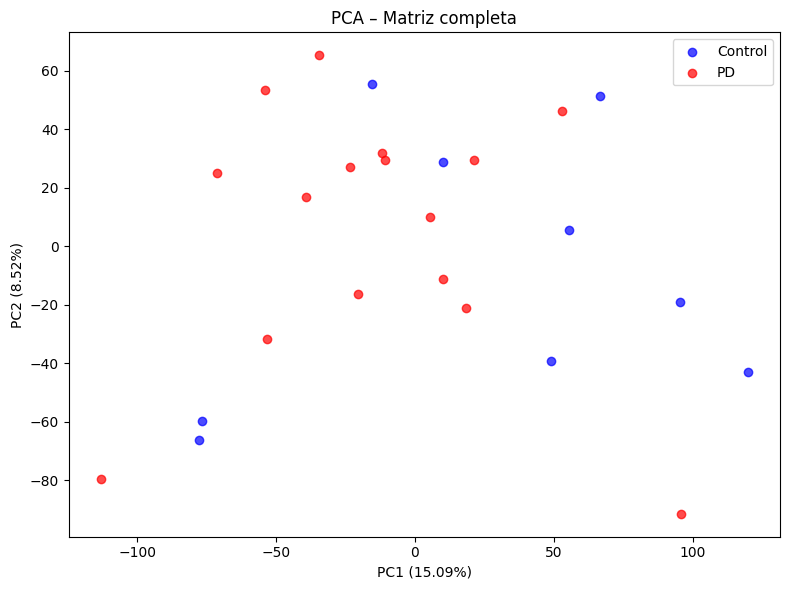

In [ ]:
# figura PCA por condición
plt.figure(figsize=(8,6))
palette = {"Control":"blue", "PD":"red"}
for grp in classes:
    idx = (y_names == grp)
    plt.scatter(X_pca2[idx,0], X_pca2[idx,1], label=grp, alpha=0.7, c=palette.get(grp,"gray"))
plt.xlabel(f"PC1 ({pca_vis.explained_variance_ratio_[0]:.2%})")
plt.ylabel(f"PC2 ({pca_vis.explained_variance_ratio_[1]:.2%})")
plt.title("PCA – Matriz completa")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "PCA_matriz_completa.png", dpi=300)
plt.show()

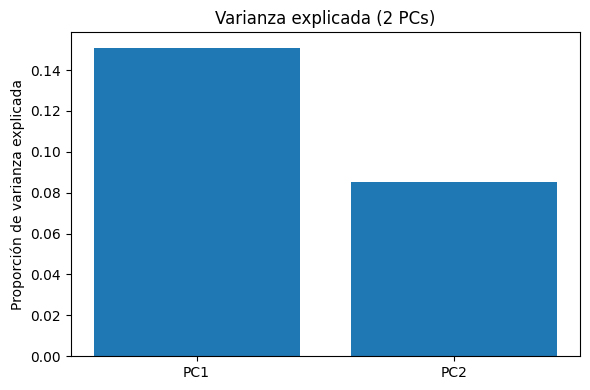

In [ ]:
# barras de varianza explicada (para 2 PCs)
plt.figure(figsize=(6,4))
plt.bar(range(1,3), pca_vis.explained_variance_ratio_, tick_label=["PC1","PC2"])
plt.ylabel("Proporción de varianza explicada")
plt.title("Varianza explicada (2 PCs)")
plt.tight_layout()
plt.savefig(FIG_DIR / "PCA_varianza_2PCs.png", dpi=300)
plt.show()

# 📊 Clustering


---

En esta sección evalúo si las muestras se agrupan solas en función de su perfil de expresión. Uso una combinación estándar: PCA para comprimir información y K-Means para asignar clústeres, más clustering jerárquico como contraste. El objetivo es un chequeo exploratorio: ver estructura, detectar outliers y comprobar si aparece una separación compatible con Control/PD sin usar etiquetas.


## 🧮 PCA para Clustering

---

Aplico PCA sin fijar n_components para obtener un embedding de baja dimensión que conserve la mayor varianza posible. Ese embedding alimenta a K-Means y mejora su estabilidad

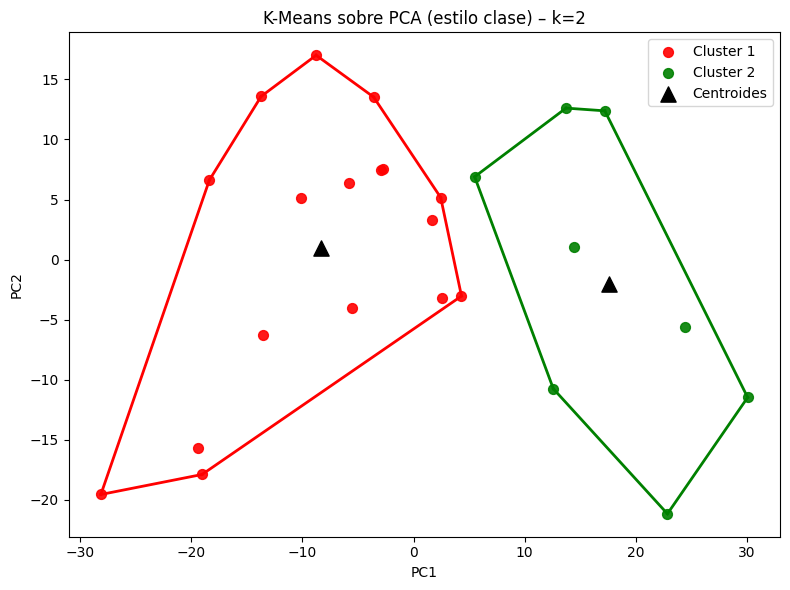

Tabla de confusión optimizada:
          0  1
Cluster       
0        13  4
1         3  5

Direct agreement: 72.00%


In [ ]:
# PCA sin n_components
pca_clust = PCA()
X_pca_all = pca_clust.fit_transform(X_mm)

# elegir k
k = len(classes) if K_CLUSTERS is None else int(K_CLUSTERS)

kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=50)
y_pred = kmeans.fit_predict(X_pca_all)
centroids = kmeans.cluster_centers_

# gráfico con centroides + convex hull
plt.figure(figsize=(8,6))
base_colors = ['red','green','blue','orange','purple','brown','pink','gray','olive','cyan']
colors = base_colors[:k]

for i in range(k):
    pts = X_pca_all[y_pred == i]
    if pts.shape[0] == 0:
        continue
    plt.scatter(pts[:,0], pts[:,1], c=colors[i], label=f'Cluster {i+1}', s=50, alpha=0.9)
    if pts.shape[0] >= 3:
        hull = ConvexHull(pts[:, :2])
        for simplex in hull.simplices:
            plt.plot(pts[simplex,0], pts[simplex,1], color=colors[i], lw=2)

plt.scatter(centroids[:,0], centroids[:,1], marker='^', s=120, c='black', label='Centroides')
plt.title(f"K-Means sobre PCA (estilo clase) – k={k}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "PCA_kmeans_overlay.png", dpi=300)
plt.show()

# matriz de confusión optimizada (Hungarian)
cont_table = pd.crosstab(y_pred, y_int, rownames=['Cluster'], colnames=['Clase real'])
row_ind, col_ind = linear_sum_assignment(-cont_table.values)
opt_table = cont_table.iloc[:, col_ind]
opt_table.columns = list(range(opt_table.shape[1]))  # opcional

print("Tabla de confusión optimizada:")
print(opt_table)

# mapear cluster → clase asignada
cluster_to_class_idx = {row_ind[i]: col_ind[i] for i in range(len(row_ind))}
matched_labels = np.array([cluster_to_class_idx[c] for c in y_pred])

direct_agreement = accuracy_score(y_int, matched_labels) * 100
print(f"\nDirect agreement: {direct_agreement:.2f}%")

# guardar salidas de clustering
opt_table.to_csv(TAB_DIR / "confusion_kmeans_vs_condition_optimized.tsv", sep="\t")
cont_table.to_csv(TAB_DIR / "confusion_kmeans_vs_condition.tsv", sep="\t")

pd.DataFrame({
    "sample": X_df.index,
    "PC1": X_pca_all[:,0],
    "PC2": X_pca_all[:,1],
    "condition": y_names,
    "kmeans_cluster": y_pred,
    "matched_class_idx": matched_labels,
    "matched_class_name": [classes[i] for i in matched_labels]
}).to_csv(TAB_DIR / "PCA_scores_and_kmeans.tsv", sep="\t", index=False)

pd.DataFrame([{
    "k": k,
    "Direct_agreement_%": round(direct_agreement, 2),
    "PC1_var%": round(pca_clust.explained_variance_ratio_[0]*100, 2) if pca_clust.explained_variance_ratio_.size>=1 else np.nan,
    "PC2_var%": round(pca_clust.explained_variance_ratio_[1]*100, 2) if pca_clust.explained_variance_ratio_.size>=2 else np.nan
}]).to_csv(TAB_DIR / "clustering_metrics_basic.tsv", sep="\t", index=False)

## 📊 Jerarquico


---
Repito el análisis con tres métodos de enlace para ver si la estructura es robusta al algoritmo. Muestro dendrogramas (con línea de corte en k=2) y el scatter en PC1–PC2 coloreado por los clústeres jerárquicos. Vuelvo a calcular matrices de confusión optimizadas y acuerdo (%) para comparar contra K-Means.



Tabla de confusión optimizada (single linkage):
          0  1
Cluster       
1        16  8
2         0  1
Direct agreement (single linkage): 68.00%

Tabla de confusión optimizada (complete linkage):
         0   1
Cluster       
1        2   1
2        7  15
Direct agreement (complete linkage): 68.00%

Tabla de confusión optimizada (average linkage):
         0   1
Cluster       
1        2   1
2        7  15
Direct agreement (average linkage): 68.00%


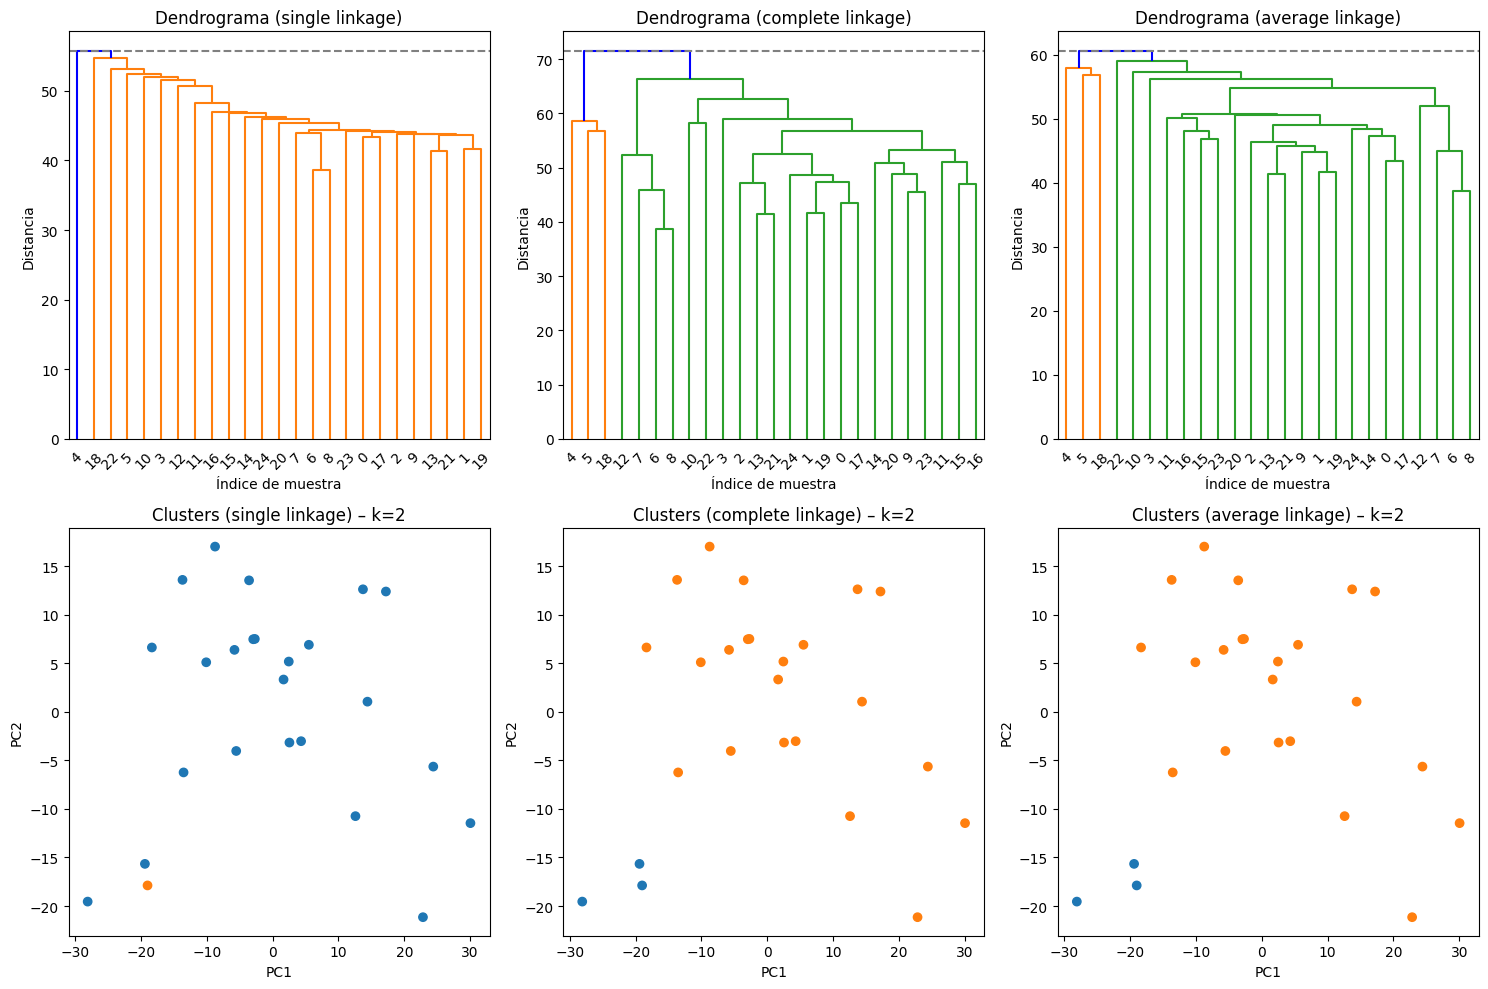

[Jerárquico] Figuras en figures y tablas por método en analysis.


In [ ]:
LINKAGE_METHODS = ['single', 'complete', 'average']
N_CLUSTERS = len(classes)

try:
    X_pca_h = X_pca_all
except NameError:
    pca_h = PCA()
    X_pca_h = pca_h.fit_transform(X_mm)

# Helper para dendrograma con línea de corte a n clusters
def plot_dendrogram_with_cut(Z, ax, n_clusters):
    # altura de corte aproximada para n clusters (heurística estándar)
    # Tomamos el umbral como la distancia del merge que deja n clusters:
    # fila -n+1 de Z tiene el último merge que produce n-1 clusters; usamos ese nivel.
    if n_clusters <= 1 or n_clusters > Z.shape[0]+1:
        color_threshold = None
    else:
        color_threshold = Z[-n_clusters+1, 2]
    dendrogram(Z, ax=ax, color_threshold=color_threshold, above_threshold_color='blue')
    if color_threshold is not None:
        ax.axhline(y=color_threshold, color='gray', linestyle='--')
    ax.set_xlabel('Índice de muestra')
    ax.set_ylabel('Distancia')

# Figura 2x3: arriba dendrogramas, abajo scatters
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Colores para clusters
color_list = list(mcolors.TABLEAU_COLORS.values())
if len(color_list) < N_CLUSTERS:
    # si faltan colores, extendemos con otra paleta simple
    extra = ['#e41a1c','#4daf4a','#377eb8','#984ea3','#ff7f00','#a65628','#f781bf','#999999']
    color_list = (color_list + extra)[:N_CLUSTERS]

# Recorremos métodos de linkage
for i, method in enumerate(LINKAGE_METHODS):
    # 1) Jerárquico en el espacio PCA
    Z = linkage(X_pca_h, method=method)
    y_pred_h = fcluster(Z, t=N_CLUSTERS, criterion='maxclust')   # labels 1..N_CLUSTERS

    # 2) Dendrograma con línea de corte
    axs[0, i].set_title(f'Dendrograma ({method} linkage)')
    plot_dendrogram_with_cut(Z, axs[0, i], n_clusters=N_CLUSTERS)

    # 3) Scatter de los dos primeros PCs coloreado por cluster jerárquico
    scatter_colors = [color_list[c-1] for c in y_pred_h]  # y_pred_h empieza en 1
    sc = axs[1, i].scatter(X_pca_h[:, 0], X_pca_h[:, 1], c=scatter_colors)
    axs[1, i].set_title(f'Clusters ({method} linkage) – k={N_CLUSTERS}')
    axs[1, i].set_xlabel('PC1')
    axs[1, i].set_ylabel('PC2')

    # 4) Métricas: matriz de confusión optimizada (Hungarian) y Direct agreement
    # y_int son las clases reales como enteros (0..C-1) construidos en la preparación A)
    cont_table = pd.crosstab(y_pred_h, y_int, rownames=['Cluster'], colnames=['Clase real'])
    _, class_match = linear_sum_assignment(-cont_table)
    optimized_cont_table = cont_table.iloc[:, class_match]

    # columnas 0..C-1 (opcional, estilo clase)
    optimized_cont_table.columns = list(range(optimized_cont_table.shape[1]))

    print(f"\nTabla de confusión optimizada ({method} linkage):")
    print(optimized_cont_table)

    # Mapear etiquetas de cluster (1..k) a clases reales según matching
    # Ojo con el offset de fcluster (arranca en 1)
    matched_labels = np.array([class_match[c-1] for c in y_pred_h])
    direct_agreement = accuracy_score(y_int, matched_labels) * 100
    print(f"Direct agreement ({method} linkage): {direct_agreement:.2f}%")

    # Guardar tabla de confusión de cada método
    optimized_cont_table.to_csv(TAB_DIR / f"hier_confusion_{method}_optimized.tsv", sep="\t")

plt.tight_layout()
plt.savefig(FIG_DIR / f"Hierarchical_overview_{N_CLUSTERS}clusters.png", dpi=300)
plt.show()

print(f"[Jerárquico] Figuras en {FIG_DIR} y tablas por método en {TAB_DIR}.")


## 📊 Heatmap global + jerarquico por muestras

---
Selecciono los genes más variables (1500) y construyo un heatmap con z-score por gen, clustering por correlación en filas y columnas. Las barras de color (condición y, si aplica, clúster K-Means) ayudan a leer patrones coordinados.


/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


[Heatmap] Figuras guardadas en figures, órdenes en analysis


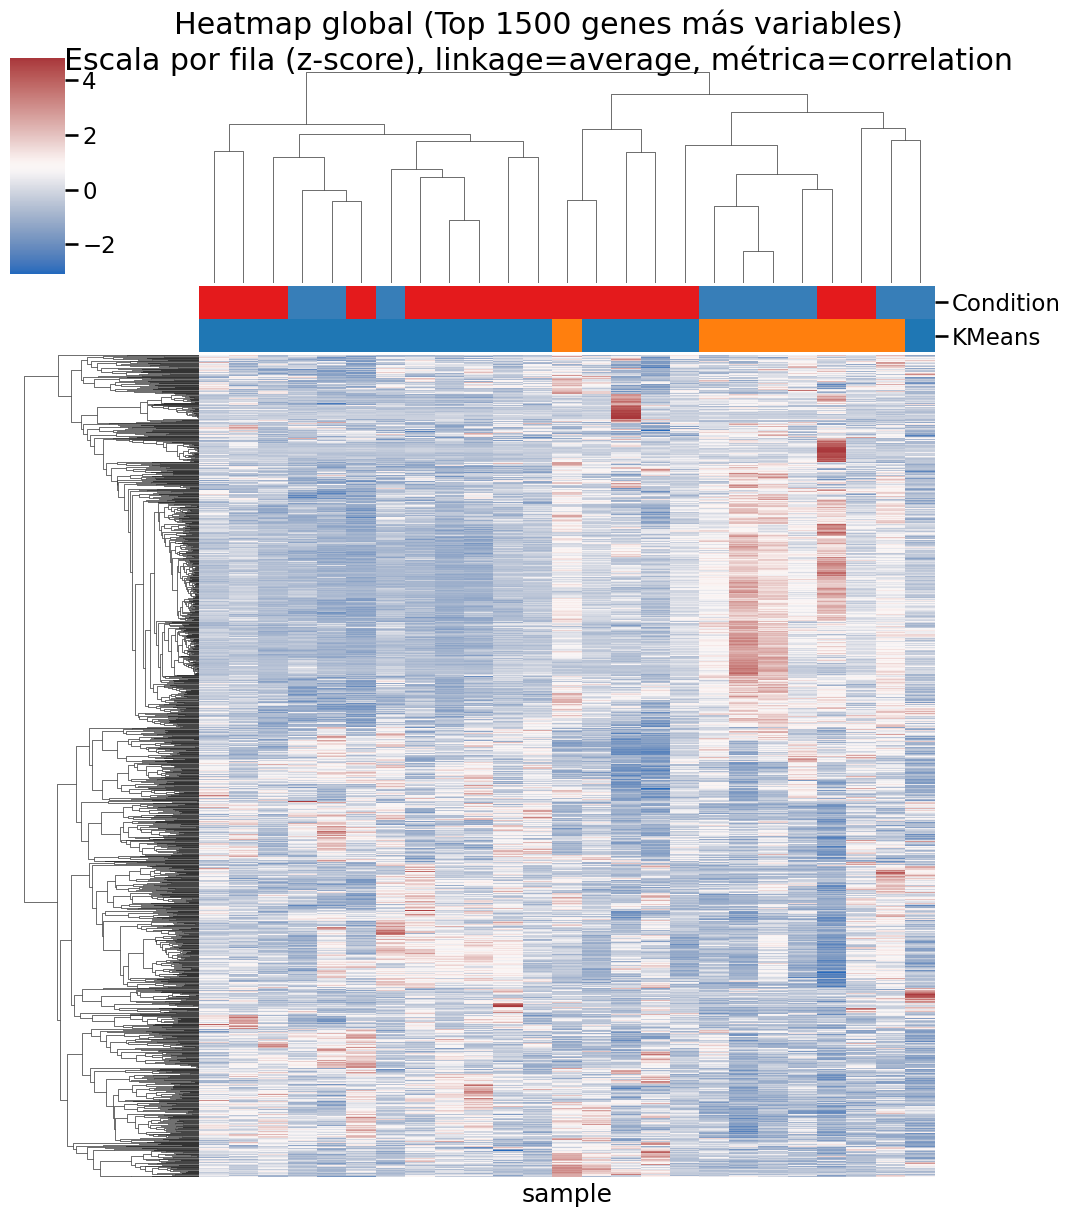

In [ ]:
# --- Configuración ---
TOP_VAR_GENES = 1500
LINKAGE_METHOD = "average"
DIST_METRIC = "correlation"

# 1) Selección de genes más variables
gene_var = X_df.var(axis=0).sort_values(ascending=False)
sel_genes = gene_var.head(min(TOP_VAR_GENES, len(gene_var))).index

# 2) Matriz genes × muestras (para heatmap)
X_heat = X_df.loc[:, sel_genes].T   # filas = genes, columnas = muestras

# 3) Barras de color para las muestras
# a) Condición real
cond_palette = {"Control": "#377eb8", "PD": "#e41a1c"}
cond_colors = [cond_palette.get(c, "#999999") for c in y_names]

# b) Cluster K-Means si existe
try:
    k = len(np.unique(y_pred))
    km_palette = {i: plt.cm.tab10(i) for i in range(k)}
    km_colors = [km_palette[int(c)] for c in y_pred]
    col_colors = pd.DataFrame({"Condition": cond_colors, "KMeans": km_colors}, index=X_df.index)
except NameError:
    col_colors = pd.DataFrame({"Condition": cond_colors}, index=X_df.index)

# 4) Clustermap
sns.set_context("talk")
g = sns.clustermap(
    X_heat,
    method=LINKAGE_METHOD,
    metric=DIST_METRIC,
    z_score=0,               # z-score por fila (gen)
    col_cluster=True,
    row_cluster=True,
    col_colors=col_colors,
    cmap="vlag",
    xticklabels=False,
    yticklabels=False,
    figsize=(11, 12)
)

g.fig.suptitle(
    f"Heatmap global (Top {len(sel_genes)} genes más variables)\n"
    f"Escala por fila (z-score), linkage={LINKAGE_METHOD}, métrica={DIST_METRIC}",
    y=1.02
)

# 5) Guardar
g.savefig(FIG_DIR / "Heatmap_muestras.png", dpi=300, bbox_inches="tight")

# 6) Guardar órdenes de dendrograma
sample_order = X_df.index[g.dendrogram_col.reordered_ind]
gene_order = X_heat.index[g.dendrogram_row.reordered_ind]

sample_order.to_series().to_csv(TAB_DIR / "heatmap_sample_order.tsv", sep="\t", index=False)
gene_order.to_series().to_csv(TAB_DIR / "heatmap_gene_order.tsv", sep="\t", index=False)

print(f"[Heatmap] Figuras guardadas en {FIG_DIR}, órdenes en {TAB_DIR}")


#🧬 Varianza de genes


---
Objetivo:

---



Quedarnos con los genes que realmente aportan a la variabilidad en el dataset, descartando ruido.
Esto se hace calculando la varianza (o desvío estándar) de cada gen a lo largo de las muestras y seleccionando los top 500–1000 más variables.

In [ ]:
# Calcular varianza por gen
varianzas = X_df.var(axis=0)

# Ordenar de mayor a menor
top_var = varianzas.sort_values(ascending=False)

# Seleccionar top 500 genes (puede ajustar a 500 o 1500 según convenga)
top_genes = top_var.head(500)

# Guardar lista de genes
top_genes.to_csv("analysis/TopVar500_genes.tsv", sep="\t", header=["Variance"])

print(f"Seleccionados {len(top_genes)} genes más variables")


Seleccionados 500 genes más variables


## 📊 Nuevo Heatmap con los 500 genes

---

Con esos 500 genes, rehago el heatmap para ver bloques de coexpresión nítidos. Mantengo z-score por gen y clustering por correlación. Esta vista valida que el subconjunto elegido realmente captura patrones biológicamente plausibles.

/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


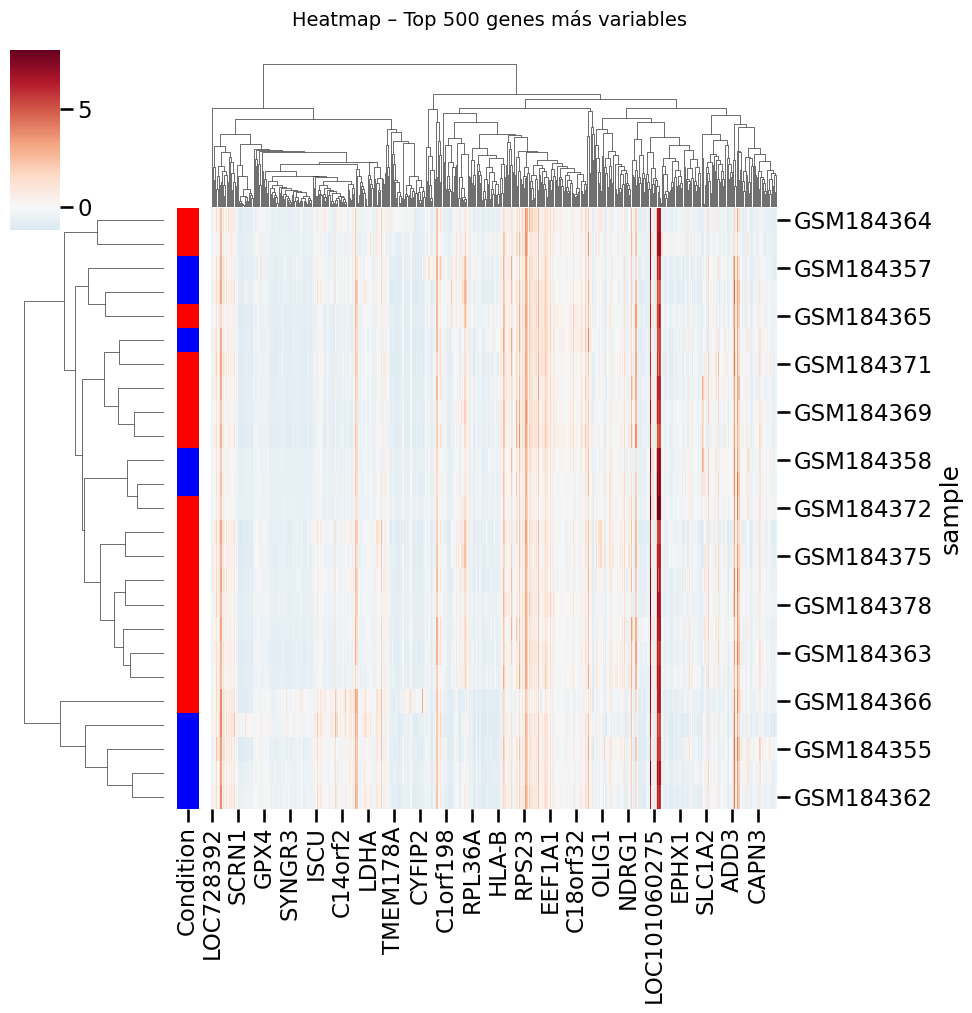

In [ ]:
# === 1. Cargar lista de genes seleccionados ===
top_genes = pd.read_csv("analysis/TopVar500_genes.tsv", sep="\t", index_col=0)
genes_usados = top_genes.index

# === 2. Subset de X_df (muestras x genes seleccionados) ===
X_top = X_df[genes_usados]

# === 3. Escalar por fila (z-score por gen) ===
X_scaled = StandardScaler(with_mean=True, with_std=True).fit_transform(X_top.T)
X_scaled = pd.DataFrame(X_scaled.T, index=X_top.index, columns=X_top.columns)

# === 4. Anotadores (Condition y KMeans cluster, si lo tenés)
row_colors = pd.DataFrame({
    "Condition": metadata["condition"].map({"Control":"blue", "PD":"red"}).values
}, index=metadata["sample"])

# Si querés agregar también el cluster de KMeans:
# row_colors["KMeans"] = kmeans_labels.map({0:"orange", 1:"green"})

# === 5. Heatmap con clustermap ===
g = sns.clustermap(
    X_scaled,
    method="average", metric="correlation",
    cmap="RdBu_r", center=0,
    col_cluster=True, row_cluster=True,
    row_colors=row_colors,
    figsize=(10, 10)
)

plt.suptitle("Heatmap – Top 500 genes más variables", y=1.02, fontsize=14)
plt.savefig("figures/Heatmap_TopVar500_genes.png", dpi=300, bbox_inches="tight")
plt.show()

# 🌐 Red de Co - expresion sobre top genes


---


Esta red es la base del análisis posterior (integración con STRING/Cytoscape), donde identifico hubs y evalúo proximidad a SNCA para la priorización de candidatos.


- Construyo la red gen–gen con correlaciones (|r| ≥ 0.85) para priorizar relaciones robustas.

- Genero aristas entre genes fuertemente coexpresados.

- Me quedo con la componente gigante para evitar nodos sueltos.

- Detecto módulos con Louvain (o greedy si no está disponible).

- Calculo Degree (métrica principal para hubs) y Betweenness (opcional, mediadores).



[Coexp] Aristas guardadas: 2504 (umbral |r| ≥ 0.85)
[Coexp] Nodos en componente gigante: 208 | Aristas: 2417
[Coexp] Nodos exportados: 208 | Módulos detectados: 8


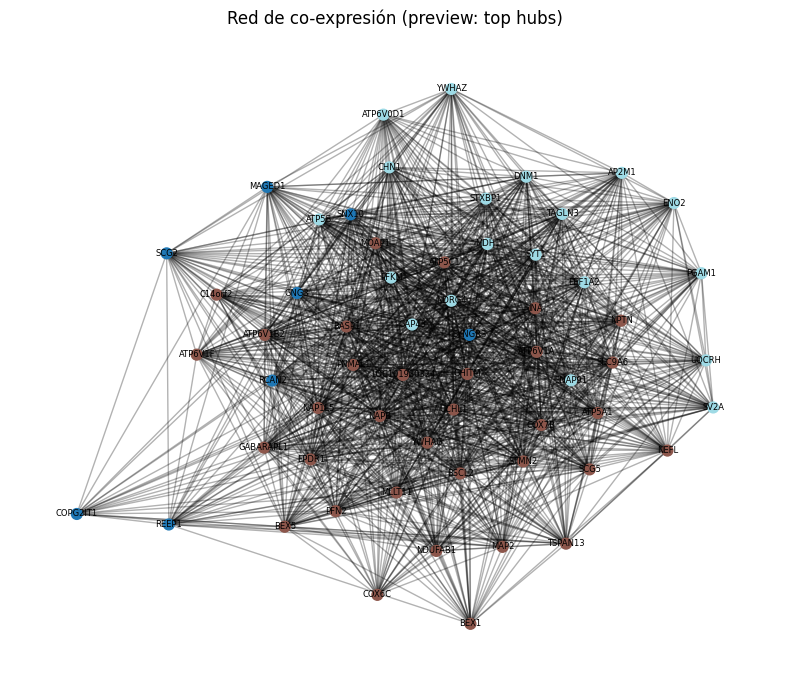

In [ ]:
FIG_DIR = Path("figures"); FIG_DIR.mkdir(exist_ok=True)
TAB_DIR = Path("analysis"); TAB_DIR.mkdir(exist_ok=True)

# --- Parámetros ---
TOP_FILE = TAB_DIR / "TopVar500_genes.tsv"
R_THRESH = 0.85                       # umbral de |r| para crear aristas
USE_ABS = True                           # si True, umbral en |r|; si False, sólo r >= R_THRESH

# --- 1) Submatriz con top genes ---
top_genes = pd.read_csv(TOP_FILE, sep="\t", index_col=0).index
X_top = X_df.loc[:, X_df.columns.intersection(top_genes)]   # muestras x genes (sólo top)
# Correlación gen–gen a través de muestras
corr = pd.DataFrame(np.corrcoef(X_top.T), index=X_top.columns, columns=X_top.columns)

# --- 2) Construir lista de aristas desde la matriz de correlación ---
corr_values = corr.values
np.fill_diagonal(corr_values, 0.0)  # evitar auto-bucles
if USE_ABS:
    mask = np.triu(np.abs(corr_values) >= R_THRESH, k=1)
else:
    mask = np.triu(corr_values >= R_THRESH, k=1)

edges = []
genes = corr.index.to_list()
rows, cols = np.where(mask)
for i, j in zip(rows, cols):
    r = corr_values[i, j]
    edges.append((genes[i], genes[j], float(r)))

edges_df = pd.DataFrame(edges, columns=["source", "target", "weight_r"])

# Guardar aristas
edges_df.to_csv(TAB_DIR / "Coexpr_edges.tsv", sep="\t", index=False)
print(f"[Coexp] Aristas guardadas: {len(edges_df)} (umbral {('|' if USE_ABS else '')}r{'|' if USE_ABS else ''} ≥ {R_THRESH})")

# --- 3) Grafo y comunidades (Louvain) ---
G = nx.Graph()
G.add_nodes_from(genes)
G.add_weighted_edges_from([(s, t, w) for s, t, w in edges])

# Si el grafo quedó muy disperso, nos quedamos con la componente gigante (opcional)
if not nx.is_empty(G):
    largest_cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_cc).copy()
    print(f"[Coexp] Nodos en componente gigante: {G.number_of_nodes()} | Aristas: {G.number_of_edges()}")

# Comunidades (Louvain si disponible; si no, greedy)
module_labels = {}
try:
    from networkx.algorithms.community import louvain_communities
    comms = louvain_communities(G, weight="weight", seed=42)
except Exception:
    from networkx.algorithms.community import greedy_modularity_communities
    comms = greedy_modularity_communities(G, weight="weight")

for m_idx, comm in enumerate(comms, start=1):
    for g in comm:
        module_labels[g] = f"M{m_idx}"

# --- 4) Métricas de nodo ---
deg_dict = dict(G.degree(weight=None))               # grado no ponderado para hubs simples
btw_dict = nx.betweenness_centrality(G, normalized=True) if G.number_of_nodes() <= 5000 else {n: np.nan for n in G}

# Tabla de nodos
nodes_df = pd.DataFrame({
    "Gene": list(G.nodes()),
    "Module": [module_labels.get(n, "M0") for n in G.nodes()],
    "Degree": [deg_dict.get(n, 0) for n in G.nodes()],
    "Betweenness": [btw_dict.get(n, np.nan) for n in G.nodes()]
}).sort_values(["Module", "Degree"], ascending=[True, False])

nodes_df.to_csv(TAB_DIR / "Coexpr_nodes.tsv", sep="\t", index=False)
print(f"[Coexp] Nodos exportados: {len(nodes_df)} | Módulos detectados: {len(set(nodes_df['Module']))}")

# --- 5) (Opcional) Listas por módulo para enriquecimiento ---
for m in sorted(nodes_df["Module"].unique()):
    mod_genes = nodes_df.loc[nodes_df["Module"] == m, "Gene"]
    mod_genes.to_csv(TAB_DIR / f"Module_{m}_genes.tsv", sep="\t", index=False, header=False)

# --- 6) (Opcional) Preview rápido de la red (subgrafo de hubs) ---
try:
    import matplotlib.pyplot as plt
    # Tomamos los top hubs para vista rápida (evitar bolas de pelo en 2D)
    top_hubs = nodes_df.sort_values("Degree", ascending=False).head(60)["Gene"].tolist()
    H = G.subgraph(top_hubs).copy()
    plt.figure(figsize=(8,7))
    pos = nx.spring_layout(H, seed=42, k=0.25)
    # Colores por módulo
    mods = {n: module_labels.get(n, "M0") for n in H.nodes()}
    mod_ids = {m:i for i, m in enumerate(sorted(set(mods.values())))}
    node_colors = [mod_ids[mods[n]] for n in H.nodes()]
    nx.draw_networkx_nodes(H, pos, node_size=60, node_color=node_colors, cmap="tab20")
    nx.draw_networkx_edges(H, pos, alpha=0.3)
    nx.draw_networkx_labels(H, pos, font_size=6)
    plt.axis("off")
    plt.title("Red de co-expresión (preview: top hubs)")
    plt.tight_layout()
    plt.savefig(FIG_DIR / "Red_coexpresion_preview.png", dpi=300)
    plt.show()
except Exception as e:
    print(f"[Coexp] Vista previa omitida ({e}). La red completa podés verla en Cytoscape/Gephi.")
